<a href="https://colab.research.google.com/github/Delfrin123/Latihan-1.-Matriks-Dekomposisi-Audrey-Delfrin-Dexcel-Kirono/blob/main/Latihan_1_Dekomposisi_Matriks_KomStat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Audrey Clarissa 2106724864

Delfrin Adiyatma Situmeang 2106759722

Dexcel Oswald Otniel 2106726932

Kirono Dwi Saputro 2106656365

# **Importing Modules**

In [ ]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from spacy.lang.en.stop_words import STOP_WORDS as stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
%precision 4
plt.style.use('ggplot')
pd.set_option("display.max_colwidth", 200)

# **Loading the Data**

In [ ]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [ ]:
documents[:4]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [ ]:
print("Total Documents: ", len(documents))

Total Documents:  11314


In [ ]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Diperoleh informasi bahwa *dataset*-nya memiliki **11.314 dokumen teks** yang terbagi menjadi **20 *newsgroups* berbeda**



# **Pre-Processing the Data**

In [ ]:
# Mengload data ke dataframe untuk diproses lebih lanjut
news_df = pd.DataFrame({'document':documents})

# Menghapus semua elemen kecuali huruf (punctuations, angka, and simbol - simbol) 
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")


# menghapus kata - kata pendek karena jarang mengandung informasi yang penting
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


# membuat semua huruf menjadi huruf kecil
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


Jangan lupa untuk ***remove stop-words*** dari data teks karena biasanya mereka berantakan dan *hardly carry any information*. 


Contoh stop-words, seperti ‘it’, ‘they’, ‘am’, ‘been’, ‘about’, ‘because’, ‘while’, 'the', etc.


Untuk me-*remove stop-words* dari dokumennya, **teks harus di-*tokenize***, dengan *split text string* menjadi token/ kata individual. 

Nantinya, setelah stop-words sudah di-remove, kita akan "menjahit" kembali token-tokennya.

In [ ]:
# Tokenization - memecah kalimat menjadi kata - kata
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# menghapus stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization - menggabungkan kembali kata - kata menjadi kalimat
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000,
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])
X.shape

(11314, 1000)

# **Topic Modelling**

Langkah selanjutnya adalah **merepresentasikan setiap *term* dan dokumen sebagai suatu vektor**. 

Akan digunakan document-term matrix dan menguraikannya menjadi beberapa matriks. 

Kami akan menggunakan sklearn's TruncatedSVD untuk **mendekomposisi matriks**.

Karena data berasal dari 20 *newsgroup* yang berbeda, akan dicoba untuk memperoleh 20 topik untuk data teks kelompok kami. 

Jumlah topik dapat ditentukan dengan menggunakan parameter n_components.

# **Document-Term Matrix**

Katakanlah kita memiliki **m jumlah dokumen teks** dengan **n jumlah total kata unik**. Kami ingin mengekstrak **k topik dari semua data teks dalam dokumen**. Jumlah topik k harus ditentukan oleh pengguna.

Buat *document-term matrix* berbentuk m x n yang memiliki skor TF-IDF. 

Kemudian, kita akan **mereduksi dimensi matriks** di atas menjadi dimensi k (jumlah topik yang diinginkan), menggunakan **singular-value decomposition (SVD)**.

SVD menguraikan matriks menjadi 3 matriks lainnya. 

Misalkan kita ingin menguraikan matriks A menggunakan SVD. Matriks akan didekomposisi menjadi **matriks U**, **matriks S**, dan VT (**transpose matriks V**).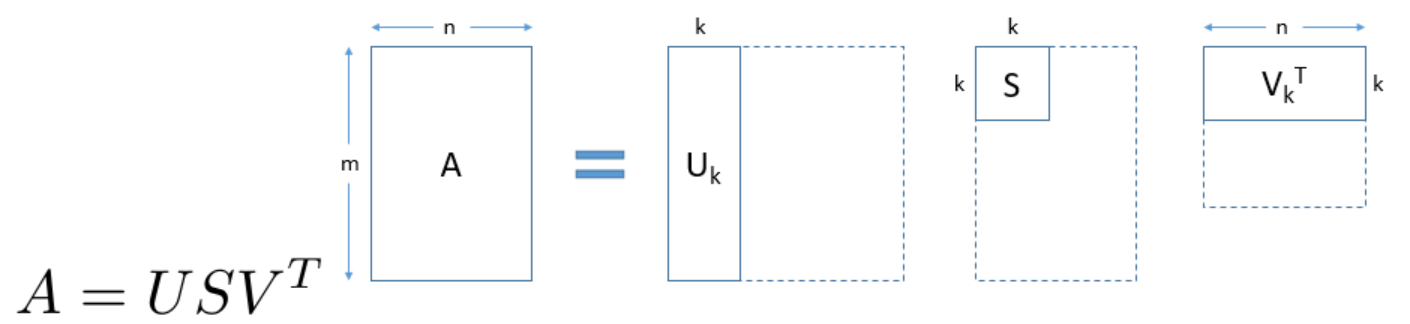

In [ ]:
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

Komponen dari svd_model adalah topik kami dan dapat diakses menggunakan svdmodel.components. 

Terakhir, akan dicetak beberapa kata terpenting di masing-masing dari 20 topik dan lihat bagaimana *performance* model kelompok kami.

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)

    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:5]
    print("Topic "+str(i)+": ", end='', flush=True)

    for t in sorted_terms:
        print(t[0], end=' ', flush=True)
    print(" ")

Topic 0: like know people think good  
Topic 1: thanks windows card drive mail  
Topic 2: game team year games season  
Topic 3: drive scsi hard disk card  
Topic 4: windows file window files program  
Topic 5: government space chip mail information 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


 
Topic 6: like bike chip sounds know  
Topic 7: card sale video monitor offer  
Topic 8: know card chip video government  
Topic 9: good know time bike problem  
Topic 10: think good chip clipper need  
Topic 11: thanks problem right bike good  
Topic 12: good people windows know sale  
Topic 13: space think know nasa problem  
Topic 14: space good card thanks people  
Topic 15: people problem game window time  
Topic 16: problem good window israel people  
Topic 17: file time problem need files  
Topic 18: need right file card files  
Topic 19: need time windows want israel  


In [ ]:
vsm = CountVectorizer(binary = False, lowercase=True, stop_words='english')
A = vsm.fit_transform(terms)

A.shape

(1000, 1000)

In [ ]:
type(A)

scipy.sparse.csr.csr_matrix

In [ ]:
X.toarray()

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.2019, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.2321, 0.    , 0.    ]])

In [ ]:
print(str(vectorizer.vocabulary_)[:1000])

{'sure': 870, 'story': 852, 'statement': 844, 'media': 534, 'israeli': 442, 'world': 985, 'having': 392, 'europe': 294, 'realize': 713, 'described': 231, 'letter': 480, 'think': 896, 'reason': 714, 'report': 732, 'clearly': 154, 'reports': 734, 'soldiers': 817, 'received': 718, 'government': 370, 'makes': 518, 'away': 73, 'look': 500, 'jews': 448, 'power': 667, 'yeah': 995, 'expect': 304, 'people': 630, 'read': 709, 'actually': 9, 'accept': 2, 'hard': 389, 'atheism': 64, 'need': 579, 'little': 492, 'faith': 314, 'logic': 497, 'runs': 758, 'sorry': 821, 'maybe': 530, 'start': 839, 'newsgroup': 584, 'forget': 340, 'points': 652, 'like': 486, 'know': 461, 'question': 702, 'sort': 822, 'arab': 46, 'countries': 203, 'want': 951, 'continue': 191, 'israel': 441, 'stop': 851, 'asking': 61, 'questions': 703, 'work': 981, 'begin': 81, 'attack': 66, 'group': 376, 'stupid': 859, 'center': 124, 'policy': 654, 'research': 739, 'change': 128, 'product': 686, 'area': 48, 'suspect': 872, 'clipper': 156

In [ ]:
U, s, V = np.linalg.svd(X.toarray())
print("ukuran-ukuran matriks = ",U.shape, s.shape, V.shape)
print(s)

ukuran-ukuran matriks =  (11314, 11314) (1000,) (1000, 1000)
[16.5153  9.9249  8.1962  7.9134  7.6131  7.3214  7.1523  6.9272  6.8798
  6.7251  6.6224  6.5455  6.4935  6.3796  6.2235  6.174   6.0712  5.9728
  5.9541  5.8926  5.8818  5.8763  5.79    5.7593  5.7185  5.6149  5.5911
  5.5503  5.5383  5.5047  5.4897  5.4768  5.4373  5.4259  5.3978  5.3874
  5.3621  5.3159  5.2778  5.2556  5.2455  5.2223  5.2036  5.1707  5.169
  5.1515  5.1232  5.1171  5.0988  5.0833  5.0699  5.0414  5.018   5.0091
  4.9973  4.9559  4.945   4.9321  4.9197  4.9111  4.9051  4.8979  4.8769
  4.8535  4.8456  4.8353  4.8262  4.8212  4.799   4.7796  4.7742  4.7514
  4.7402  4.7325  4.7266  4.7088  4.7032  4.6837  4.6809  4.6776  4.6646
  4.6621  4.6505  4.6342  4.633   4.6236  4.6153  4.5949  4.5914  4.5774
  4.5656  4.5573  4.5469  4.5406  4.5387  4.5326  4.521   4.5191  4.5045
  4.4991  4.4876  4.4813  4.4675  4.465   4.4597  4.4483  4.4444  4.4275
  4.42    4.4129  4.4048  4.3973  4.3964  4.388   4.3775  4.3658

In [ ]:
x_kata = V[0,:]
y_kata = V[1,:] 
print(vsm.vocabulary_)

{'ability': 0, 'able': 1, 'accept': 2, 'access': 3, 'according': 4, 'account': 5, 'action': 6, 'actions': 7, 'actual': 8, 'actually': 9, 'added': 10, 'addition': 11, 'additional': 12, 'address': 13, 'administration': 14, 'advance': 15, 'advice': 16, 'agencies': 17, 'agree': 18, 'algorithm': 19, 'allow': 20, 'allowed': 21, 'allows': 22, 'amendment': 23, 'america': 24, 'american': 25, 'americans': 26, 'analysis': 27, 'angeles': 28, 'anonymous': 29, 'answer': 30, 'answers': 31, 'anti': 32, 'anybody': 33, 'apparently': 34, 'appear': 35, 'appears': 36, 'apple': 37, 'application': 38, 'applications': 39, 'apply': 40, 'appreciate': 41, 'appreciated': 42, 'approach': 43, 'appropriate': 44, 'april': 45, 'arab': 46, 'archive': 47, 'area': 48, 'areas': 49, 'aren': 50, 'argument': 51, 'arguments': 52, 'armenia': 53, 'armenian': 54, 'armenians': 55, 'arms': 56, 'army': 57, 'article': 58, 'articles': 59, 'asked': 60, 'asking': 61, 'assume': 62, 'assuming': 63, 'atheism': 64, 'atheists': 65, 'attack'

In [ ]:
idx_kata = dict(map(reversed, vsm.vocabulary_.items()))
Label = [idx_kata[i] for i in range(A.shape[0])]
print(Label)

['ability', 'able', 'accept', 'access', 'according', 'account', 'action', 'actions', 'actual', 'actually', 'added', 'addition', 'additional', 'address', 'administration', 'advance', 'advice', 'agencies', 'agree', 'algorithm', 'allow', 'allowed', 'allows', 'amendment', 'america', 'american', 'americans', 'analysis', 'angeles', 'anonymous', 'answer', 'answers', 'anti', 'anybody', 'apparently', 'appear', 'appears', 'apple', 'application', 'applications', 'apply', 'appreciate', 'appreciated', 'approach', 'appropriate', 'april', 'arab', 'archive', 'area', 'areas', 'aren', 'argument', 'arguments', 'armenia', 'armenian', 'armenians', 'arms', 'army', 'article', 'articles', 'asked', 'asking', 'assume', 'assuming', 'atheism', 'atheists', 'attack', 'attempt', 'author', 'authority', 'available', 'average', 'avoid', 'away', 'background', 'base', 'baseball', 'based', 'basic', 'basically', 'basis', 'begin', 'beginning', 'belief', 'beliefs', 'believe', 'best', 'better', 'bible', 'bike', 'bios', 'bits'

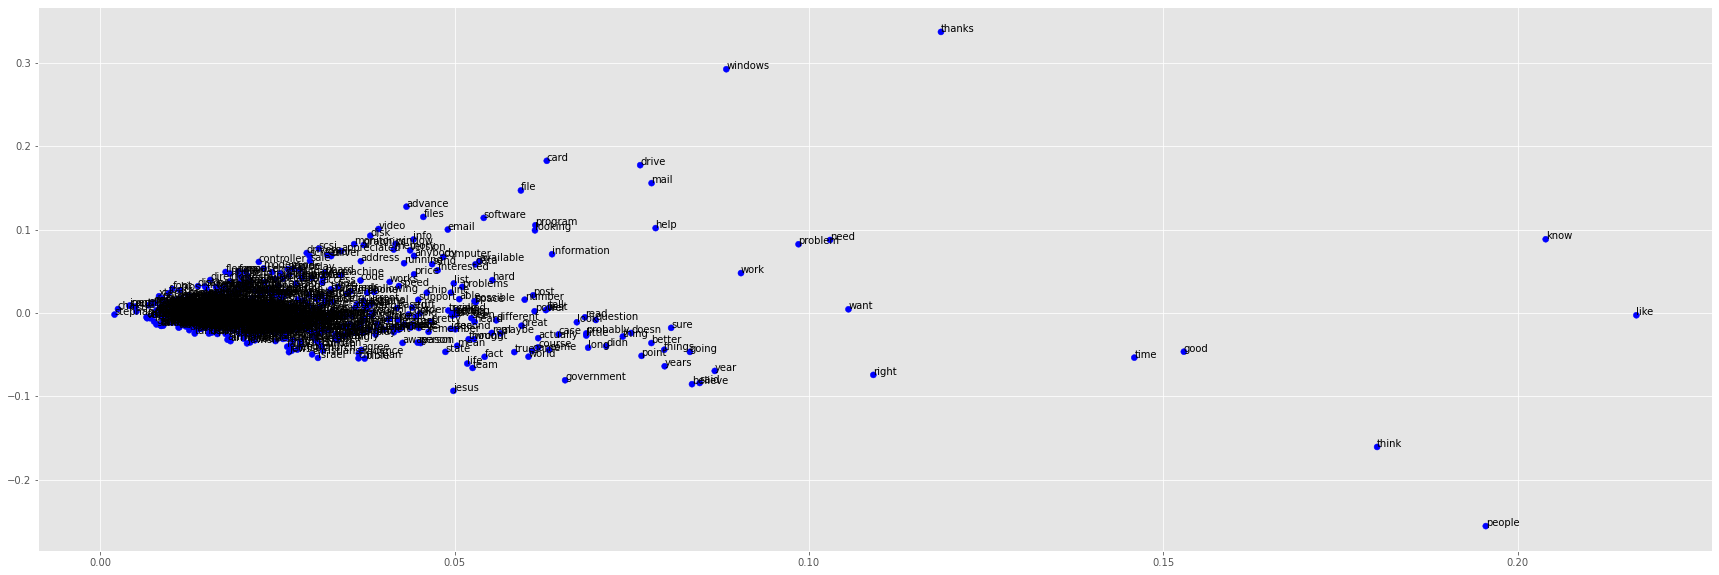

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30,10))
ax.scatter(x_kata, y_kata, c=['b']*len(x_kata))

for i, L in enumerate(Label):
    ax.annotate(L, (x_kata[i],y_kata[i]))

In [ ]:
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
c = dataset.target
embedding = TSNE(n_components=2).fit_transform(X)

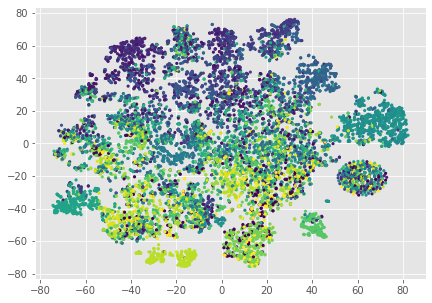

In [68]:
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c = dataset.target, s = 10, edgecolor='none')
plt.show()

Ilustrasi di atas terlihat cukup indah. Setiap titik merepresentasikan sebuah dokumen dan warna-warnanya merepresentasikan 20 *newsgroups*.